In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
to_drop=[
        "outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "y_deformation_position", "z_deformation_position",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"
        ]
to_keep=[
        "pipe_dn","pipe_schedule","flange_class",
        "length1", "length2", "lumped_mass",
        "frequency","x_deformation_position","allowable_deformation","support"
        ]

data.drop(columns=to_drop,inplace=True)

In [4]:
numeric_features = [
    "pipe_dn",
    'length1', 'length2', 'lumped_mass',
    ]
categorical_features = ['support',"pipe_schedule","flange_class"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [5]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [8]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [9]:
scaler_y_frequency = StandardScaler()
scaler_y_allowed_deformation = StandardScaler()
scaler_y_x_position = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowed_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowed_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_displacement = scaler_y_x_position.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y_x_position.transform(pd.DataFrame(y_test["x_deformation_position"]))



In [10]:
logdir = "logs/deformation_class/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [11]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(16, activation='relu')(dropout2)

# Separate output for each target variable
output_layer = Dense(1)(hidden3)
#, name='allowable_deformation'


In [12]:
model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [15]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - R2Score: 0.0857 - loss: 1.0291 - val_R2Score: 0.6840 - val_loss: 0.2921
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - R2Score: 0.6584 - loss: 0.3478 - val_R2Score: 0.8627 - val_loss: 0.1269
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - R2Score: 0.8130 - loss: 0.1875 - val_R2Score: 0.9011 - val_loss: 0.0914
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - R2Score: 0.8405 - loss: 0.1795 - val_R2Score: 0.9103 - val_loss: 0.0829
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - R2Score: 0.8678 - loss: 0.1323 - val_R2Score: 0.9166 - val_loss: 0.0771
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - R2Score: 0.8586 - loss: 0.1411 - val_R2Score: 0.9214 - val_loss: 0.0727
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - R2Score: 0.8869 - loss: 0.1169 - val_R2Score: 0.9328 - val_loss: 0.0621
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - R2Score: 0.8810 - loss: 0.1245 - val_R2Score: 0.9301

In [16]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2Score: 0.9687 - loss: 0.0355
Test accuracy: 0.9704346060752869


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,141 (43.52 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,428 (29.02 KB)

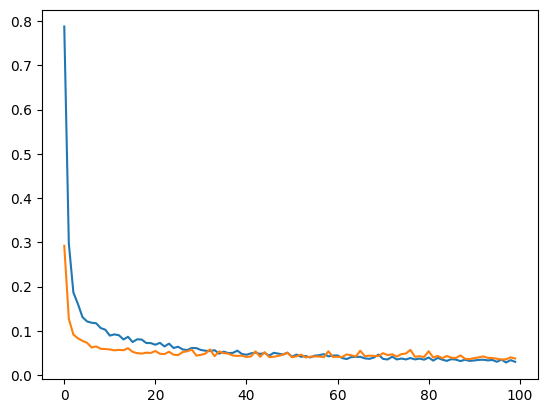

In [18]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [19]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_allowed_deformation.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [25]:
predictions_df = pd.DataFrame(predictions)
print(predictions_df)

              0
0      8.626159
1     13.580148
2      5.583821
3     19.755127
4     19.136158
...         ...
2452   3.110129
2453   2.628182
2454  -0.238763
2455   0.334143
2456  12.736411

[2457 rows x 1 columns]


In [26]:
y_test["allowable_deformation"]

524      13.586
10325    11.513
11646     5.124
10238    13.693
10214    15.469
          ...  
11507     3.243
2709      3.497
12218     2.108
2858      1.647
9935     10.959
Name: allowable_deformation, Length: 2457, dtype: float64

In [21]:
true= y_test["allowable_deformation"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

189.03849414701415

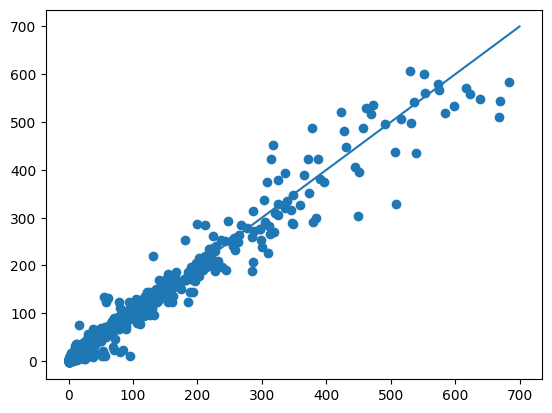

In [32]:
pred=predictions_df
ansys=y_test["allowable_deformation"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 700],[0, 700])
plt.show()

In [31]:
clear_session()
del model
gc.collect()

NameError: name 'model' is not defined